In [1]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
#from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel

pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2*np.pi*1*x)*7.+8. #*np.sin(2*np.pi*3*x+.6)

(100, 2)


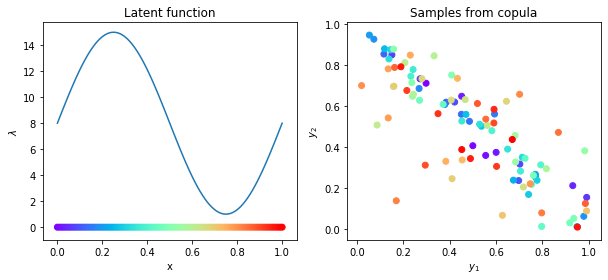

In [3]:
# here we generate some synthetic samples
import matplotlib.cm as cm

NSamp = int(1e2)

X = np.linspace(0.,1.,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

# Y = np.zeros((NSamp,2))
# copula = GaussCopula()
# for i,x in enumerate(X):
#     if scale(x) == 0:
#         Y[i] = np.random.uniform(low=0,high=1,size=2)
#     else:
#         Y[i] = np.array(copula.sample(1,scale(x))).T # size=1
scales = [scale(x) for x in X]
model = ClaytonCopula(torch.tensor(scales).float(),rotation='90°')
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0., 1., NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from copula')

fig.show()

In [4]:
scale(X)[Y[...,0]!=Y[...,0]]

array([], dtype=float64)

In [5]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float()#.cuda(device=0)
train_y = torch.tensor(Y).float()#.cuda(device=0)

In [6]:
def plot_training(filename,losses,rbf,means):
    # prot loss function and kernel length
    fig, (loss, kern, mean) = plt.subplots(1,3,figsize=(15,2))
    loss.plot(losses)
    loss.set_xlabel("Epoch #")
    loss.set_ylabel("Loss")
    loss.set_ylim(np.min(losses)*1.1,200)
    kern.plot(rbf)
    kern.set_xlabel("Epoch #")
    kern.set_ylabel("Kernel scale parameter")
    mean.plot([np.mean(x) for x in means])
    mean.set_xlabel("Epoch #")
    mean.set_ylabel("Mean f")
    fig.savefig(filename)
    
def plot_result(filename):
    # visualize the result
    fig, (func, sim, true) = plt.subplots(1,3,figsize=(15, 3))

    model.eval()
    with torch.no_grad():
        output = model(test_x)

    gplink = model.likelihood.gplink_function

    samples = output.rsample(torch.Size([2048]))
    F_mean = gplink(samples).mean(0).detach().cpu().numpy()
    #F_mean = gplink(output.mean).detach().cpu().numpy()
    line, = func.plot(testX, F_mean, label = 'GP prediction')
    lower, upper = output.confidence_region()
    func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                    gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

    func.plot(testX,scale(testX), label = 'True latent function')
    func.scatter(X,np.zeros_like(X),color=colors)
    func.set_xlabel('x')
    func.set_ylabel('gp_link(f)')
    func.set_title('Latent function')
    func.legend()

    # sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
    with gpytorch.settings.num_likelihood_samples(1):
        Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
    skip = 1
    true.scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
    sim.scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
    for ax in [sim,true]:
        ax.set_xlabel('$y_1$')
        ax.set_ylabel('$y_2$')
    sim.set_title('Samples from copula with theta=gplink(f(x))')
    true.set_title('True data samples')
    # samp.legend()

    fig.savefig(filename)

Basic lr for most of parameters: 0.001
Iter 100/2000 - Loss: 4.31   lengthscale: 0.428, dLoss: 0.0, mean f: -0.268, dmean: 1.0
Iter 200/2000 - Loss: -16.9   lengthscale: 0.452, dLoss: 23.3, mean f: -0.548, dmean: 0.505
Iter 300/2000 - Loss: -26.7   lengthscale: 0.445, dLoss: 6.39, mean f: -0.749, dmean: 0.259
Iter 400/2000 - Loss: -35.9   lengthscale: 0.418, dLoss: 3.76, mean f: -0.888, dmean: 0.15
Iter 500/2000 - Loss: -36.8   lengthscale: 0.399, dLoss: 3.11, mean f: -0.982, dmean: 0.0922
Iter 600/2000 - Loss: -43.1   lengthscale: 0.381, dLoss: 1.83, mean f: -1.05, dmean: 0.0635
Iter 700/2000 - Loss: -35.0   lengthscale: 0.364, dLoss: 1.77, mean f: -1.11, dmean: 0.0511
Iter 800/2000 - Loss: -48.8   lengthscale: 0.347, dLoss: 1.66, mean f: -1.16, dmean: 0.0415
Iter 900/2000 - Loss: -49.0   lengthscale: 0.333, dLoss: 1.54, mean f: -1.2, dmean: 0.0336
Iter 1000/2000 - Loss: -54.2   lengthscale: 0.324, dLoss: 1.17, mean f: -1.24, dmean: 0.0336
Iter 1100/2000 - Loss: -55.8   lengthscale: 0

Iter 300/2000 - Loss: -65.6   lengthscale: 0.441, dLoss: 2.28, mean f: 0.24, dmean: 0.705
Iter 400/2000 - Loss: -71.9   lengthscale: 0.428, dLoss: 2.46, mean f: 0.364, dmean: 0.533
Iter 500/2000 - Loss: -76.0   lengthscale: 0.409, dLoss: 2.39, mean f: 0.481, dmean: 0.248
Iter 600/2000 - Loss: -76.8   lengthscale: 0.388, dLoss: 1.74, mean f: 0.58, dmean: 0.169
Iter 700/2000 - Loss: -78.0   lengthscale: 0.366, dLoss: 0.823, mean f: 0.653, dmean: 0.119
Converged!
CPU times: user 23min 38s, sys: 2min 26s, total: 26min 4s
Wall time: 1min 29s
Log_probability:  71.889033203125


[57.53859375,
 65.51435546875,
 -13.258935546875,
 84.942529296875,
 -11.72320556640625,
 26.32172119140625,
 -10.685333251953125,
 38.5808154296875,
 -10.907081298828125,
 71.889033203125]

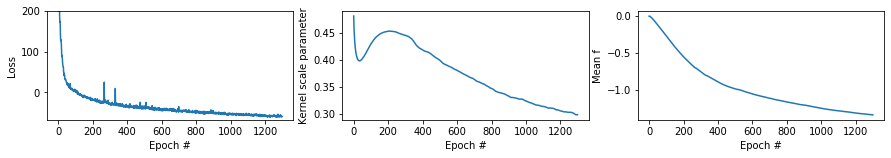

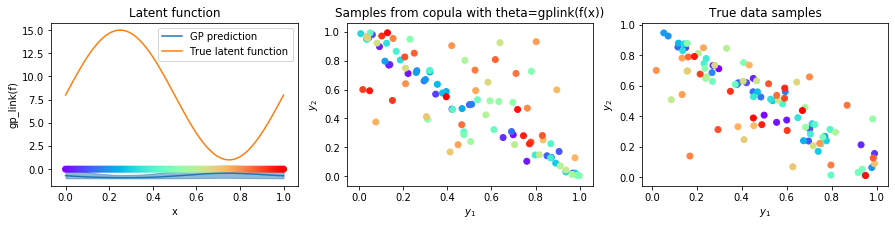

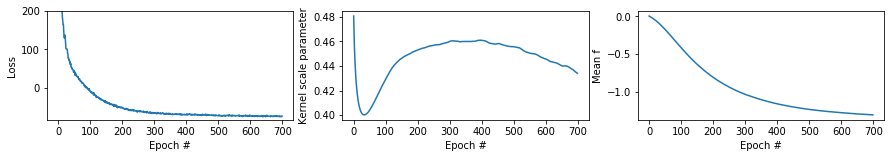

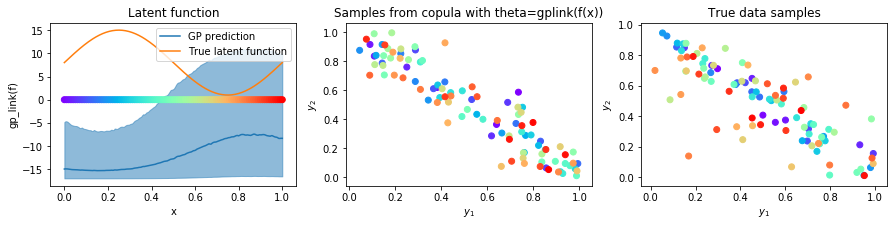

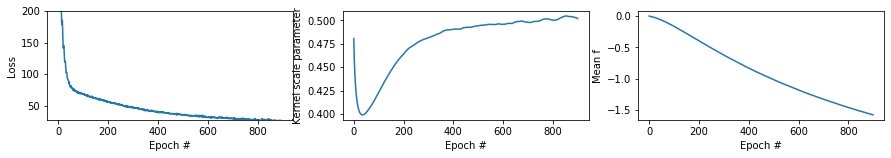

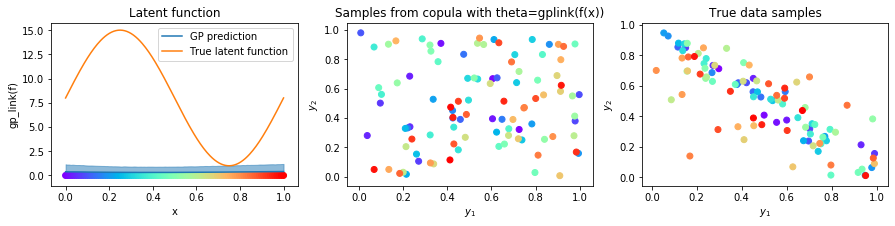

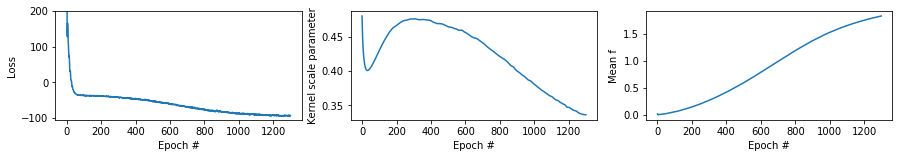

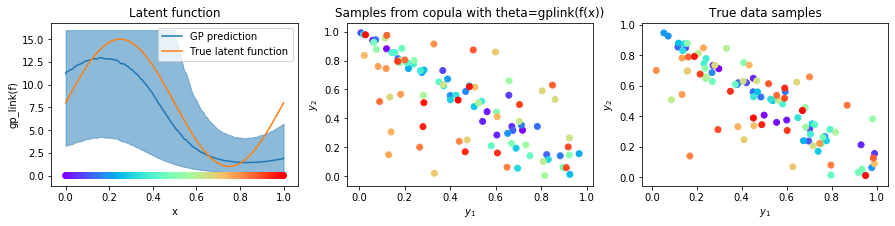

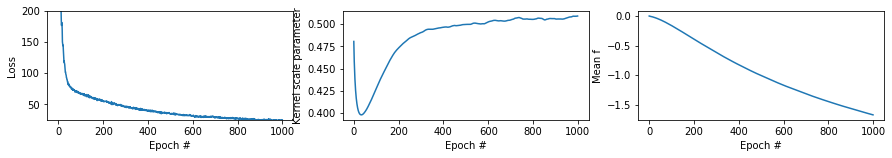

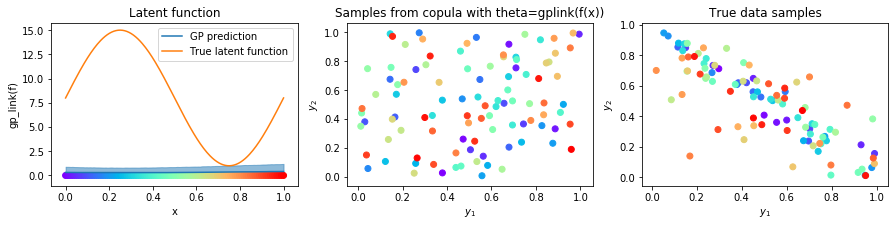

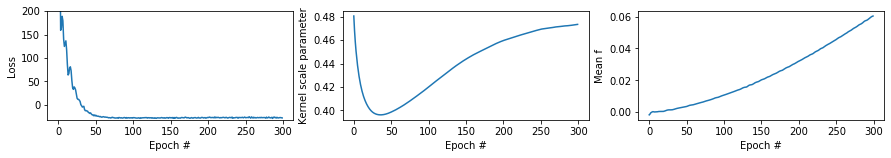

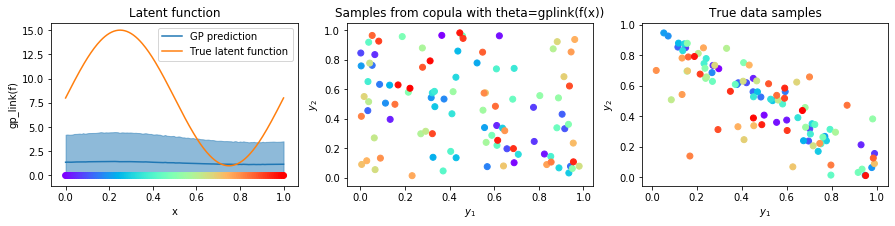

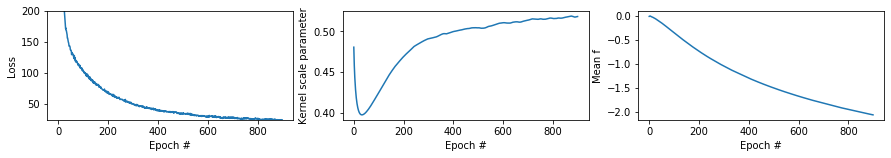

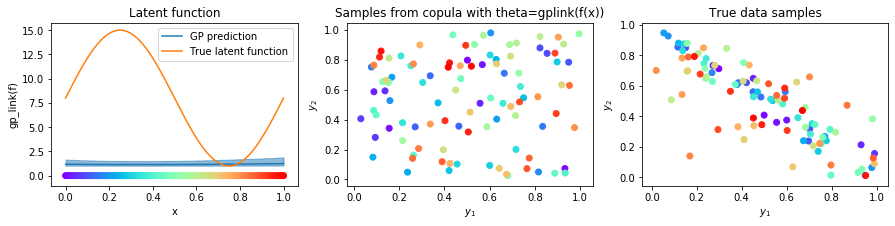

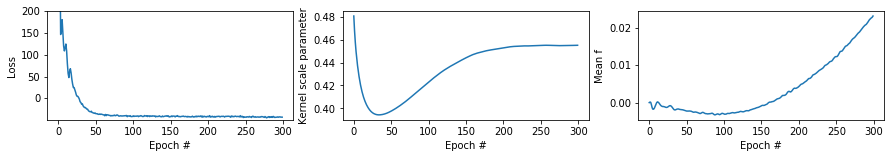

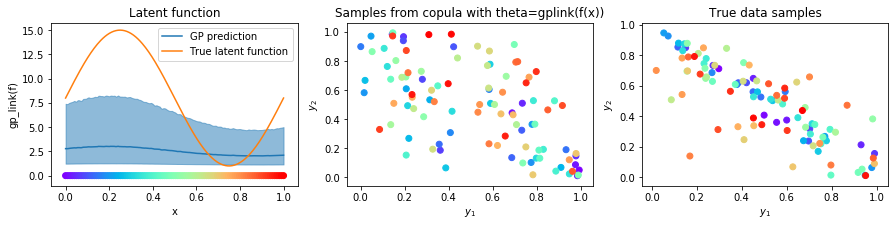

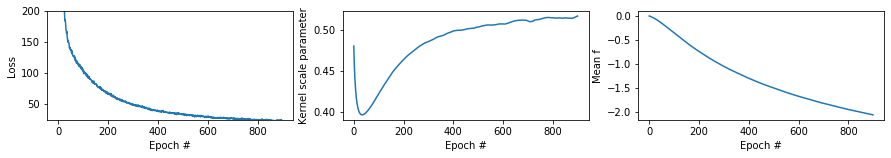

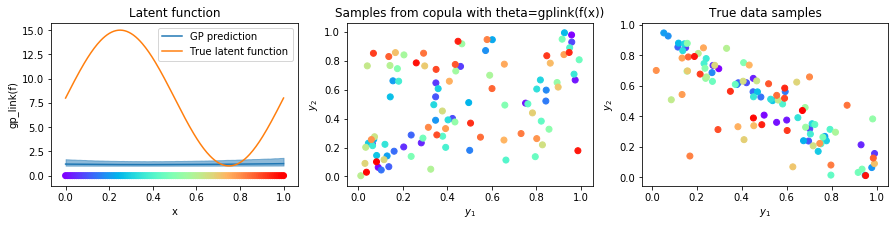

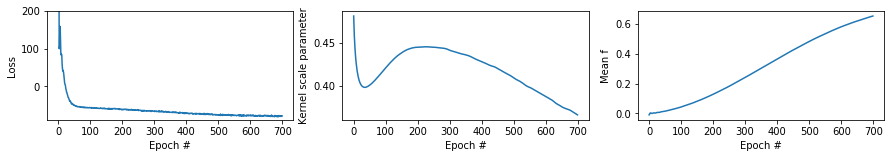

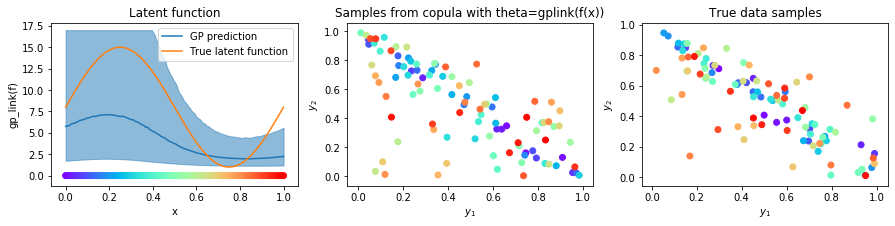

In [10]:
likelihoods_list = [GaussianCopula_Likelihood(),
                    FrankCopula_Likelihood(),
                    ClaytonCopula_Likelihood(rotation='0°'),
                   ClaytonCopula_Likelihood(rotation='90°'),
                   ClaytonCopula_Likelihood(rotation='180°'),
                   ClaytonCopula_Likelihood(rotation='270°'),
                   GumbelCopula_Likelihood(rotation='0°'),
                   GumbelCopula_Likelihood(rotation='90°'),
                   GumbelCopula_Likelihood(rotation='180°'),
                   GumbelCopula_Likelihood(rotation='270°')]

log_probs = []

# train the model
from pyro import optim
import gc

gc.collect()

grid_size = 128

def train(num_iter=2000):
    elbo = pyro.infer.Trace_ELBO(num_particles=128, vectorize_particles=True, max_plate_nesting=1)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    p = 0.
    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss)
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy().copy())
        if not (i + 1) % iter_print:
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}, dLoss: {:.3}, mean f: {:.3}, dmean: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(), mean_p, np.mean(means[-1]), np.mean(np.abs(1-means[-100]/means[-1]))
            ))
            
            #print(np.std(losses[-100:]))
            if (0 < mean_p < 1.0):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.

base_lr = 1e-3
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# set learning rates for different hyperparameters
def per_param_callable(module_name, param_name):
    if param_name == 'covar_module.base_kernel.raw_lengthscale':
        return {"lr": .05} #.1 for 256 particles
    elif param_name == 'variational_strategy.variational_distribution.variational_mean':
        return {"lr": .1}
    else:
        #print(param_name)
        return {"lr": base_lr}

# Use the adam optimizer
optimizer = optim.Adam(per_param_callable)

for lik in likelihoods_list:
    
    gc.collect()

    # define the model (optionally on GPU)
    grid_size = 128
    model = KISS_GPInferenceModel(lik, prior_rbf_length=0.5, grid_size=grid_size)#.cuda(device=0)

    pyro.clear_param_store() # clean run

    losses, rbf, means = [], [], []

    %time train()
    
    if lik.rotation:
        name = lik.copula.__name__+' '+lik.rotation[:-1]
    else:
        name = lik.copula.__name__
    
    plot_training(name+'_train.png',losses,rbf,means)
    
    # define test set (optionally on GPU)
    denser = 2 # make test set 2 times denser then the training set
    testX = np.linspace(0,1,denser*NSamp)
    test_x = torch.tensor(testX).float()#.cuda(device=0)
    
    gplink = model.likelihood.gplink_function
    N=100
    samples = model(train_x).rsample(torch.Size([N]))
    log_prob = lik.copula(gplink(samples).detach(),
                          rotation=lik.rotation).\
            log_prob(train_y).sum().cpu().numpy()/N
    print('Log_probability: ',log_prob)
    log_probs.append(log_prob)
                     
    plot_result(name+'_result.png')
log_probs

In [19]:
lik = likelihoods_list[np.argmax(log_probs)]
if lik.rotation:
    name = lik.copula.__name__+' '+lik.rotation
else:
    name = lik.copula.__name__
name

'ClaytonCopula 90°'